# POLI 179 Final Project
## Comparing across keywords
### By: Alyson Otañez 

## Latent Dirichlet Allocation (LDA) 

### 1. Count of topics of interest over time

In [1]:
# Install packages if necessary 
# ! pip install pandas
# ! pip install re 
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install warnings 

In [2]:
# Import necessary packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load data 
ie_cities = pd.read_csv('../Data/ie_cities.csv')

# Drop NA values (only 1)
ie_cities = ie_cities[ie_cities['Text'].notna()]

In [4]:
# Keywords 
industrial = ['warehouse', 'logistics', 'distribution', 'industrial', 'warehousing']
recreation = ['recreation', 'park', 'green space', 'pool', 'outdoor']
transportation = ['transportation', 'bus', 'public transport', 'transit', 'train']

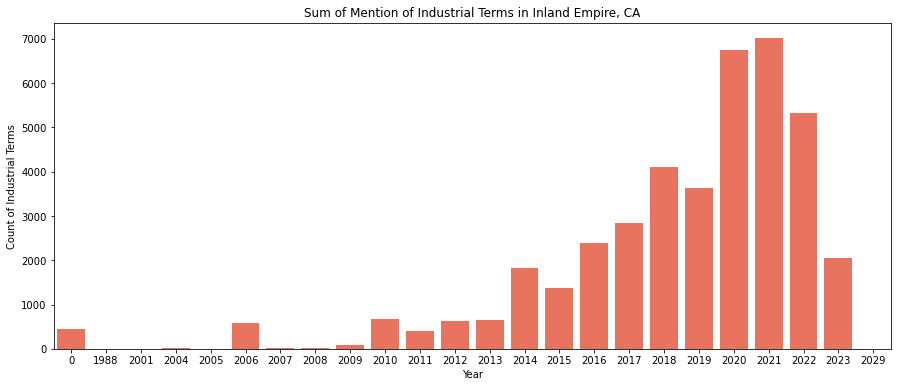

In [5]:
# Plot of industrial terms over time
def count_industrial(text):
    words = re.split(r'\s+', text.lower())  
    return sum(word in industrial for word in words)

# Apply the function to each text entry and create a new column for sums
ie_cities['Sum_Industrial'] = ie_cities['Text'].apply(count_industrial)

# Group by Year and sum the counts
yearly_counts_in = ie_cities.groupby('Year')['Sum_Industrial'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=yearly_counts_in, x='Year', y='Sum_Industrial', color='tomato')
plt.xlabel('Year')
plt.ylabel('Count of Industrial Terms')
plt.title('Sum of Mention of Industrial Terms in Inland Empire, CA')
plt.savefig('industrial_terms_plot.png')
plt.show()

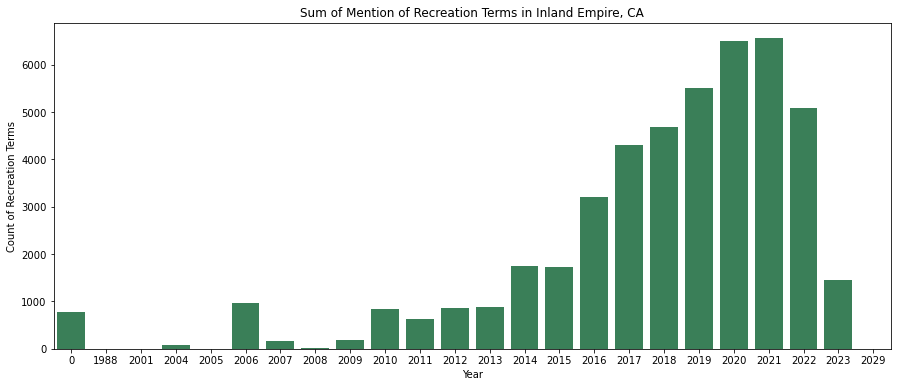

In [6]:
# Plot of recreation terms over time
def count_recreation(text):
    words = re.split(r'\s+', text.lower())  
    return sum(word in recreation for word in words)

# Apply the function to each text entry and create a new column for sums
ie_cities['Sum_Recreation'] = ie_cities['Text'].apply(count_recreation)

# Group by Year and sum the counts
yearly_counts_re = ie_cities.groupby('Year')['Sum_Recreation'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=yearly_counts_re, x='Year', y='Sum_Recreation', color='seagreen')
plt.xlabel('Year')
plt.ylabel('Count of Recreation Terms')
plt.title('Sum of Mention of Recreation Terms in Inland Empire, CA')
plt.savefig('recreation_terms_plot.png')
plt.show()

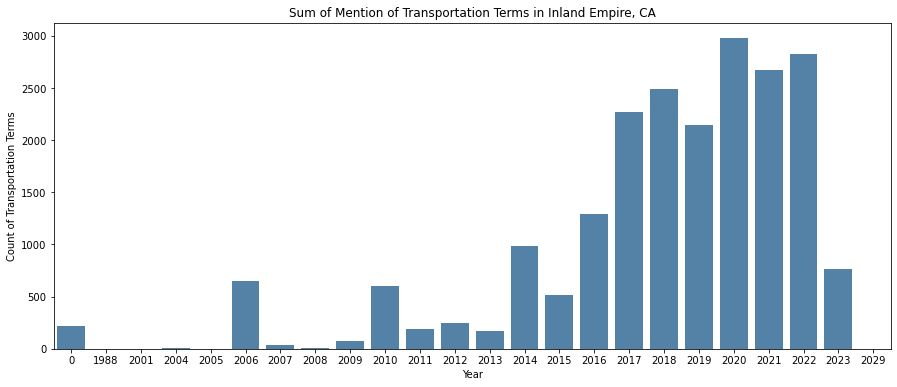

In [7]:
# Plot of transportation terms over time
def count_trans(text):
    words = re.split(r'\s+', text.lower())  
    return sum(word in transportation for word in words)

# Apply the function to each text entry and create a new column for sums
ie_cities['Sum_Transportation'] = ie_cities['Text'].apply(count_trans)

# Group by Year and sum the counts
yearly_counts_tr = ie_cities.groupby('Year')['Sum_Transportation'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=yearly_counts_tr, x='Year', y='Sum_Transportation', color='steelblue')
plt.xlabel('Year')
plt.ylabel('Count of Transportation Terms')
plt.title('Sum of Mention of Transportation Terms in Inland Empire, CA')
plt.savefig('trans_terms_plot.png')
plt.show()

### 2. Preprocess data

In [13]:
# Install packages if necessary
# ! pip install nltk
# ! pip install spacy 
# ! pip install --user gensim
# ! pip install --user pyLDAvis
# ! pip install --user gutenbergpy

In [14]:
# Import necessary packages
import pandas as pd
import os
import nltk
import re
import string
import sys
sys.path.append('/home/aotanez/.local/lib/python3.9/site-packages')
import gensim
import numpy as np
from gutenbergpy import textget
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvisualize

[nltk_data] Downloading package punkt to /home/aotanez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aotanez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aotanez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/aotanez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [15]:
# WordNet for lemmatization 
def wordnet_pos_tags(x):
    if x.startswith('J'):
        return wordnet.ADJ
    elif x.startswith('V'):
        return wordnet.VERB
    elif x.startswith('N'):
        return wordnet.NOUN
    elif x.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
# Function for preprocessing 
def txt_preprocess_pipeline(text):
    standard_txt = text.lower()
    
    clean_txt = re.sub(r'http\S+|www\S+|https\S+', '', standard_txt, flags = re.MULTILINE)
    clean_txt = re.sub(r'\n', ' ', clean_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    clean_txt = re.sub(r'\S+@\S+', '', clean_txt)
    clean_txt = re.sub(r'\\r\\n', ' ', clean_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    clean_txt = re.sub(r'<.*?>', '', clean_txt)
    clean_txt = re.sub(r'[^\w\s]', '', clean_txt)    
    clean_txt = re.sub(r'\b\w{1,2}\b', '', clean_txt)
    
    tokens = word_tokenize(clean_txt)
    filtered_tokens_alpha = [word for word in tokens if word.isalpha() and not re.match(r'^[ivxlcdm]+$', word)]
    
    stop_words = set(stopwords.words('english'))
    stop_words.update(['chino', 'fontana', 'march', 'joint', 'powers', 'authority', 
                       'http', 'rialto', 'ontario', 'city', 'council', 'agenda',
                      'meeting', 'minutes', 'back', 'site', 'main', 'welcome', 'browse', 'video',
                      'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 
                      'saturday', 'sunday', 'notice', 'commission', 'archive', 'pmcity',
                      'chamber', 'palm', 'ave', 'january', 'february', 'march', 'april', 'may',
                      'june', 'july', 'august', 'september', 'october', 'november', 'december',
                      'closed', 'session'])
    filtered_tokens_final = [w for w in filtered_tokens_alpha if not w in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(filtered_tokens_final)
    lemma_tokens = [lemmatizer.lemmatize(token, wordnet_pos_tags(pos_tag)) for token, pos_tag in pos_tags]
    
    return lemma_tokens

In [20]:
# Apply functions to data
ie_cities['Processed_Text'] = ie_cities['Text'].apply(txt_preprocess_pipeline)
ie_cities

,Text,Date,Year,City,Sum_Industrial,Sum_Recreation,Sum_Transportation,Type,Processed_Text
0,«Back to Main Site\r\n Welc...,"December 20, 2005",2005,Chino,0,1,0,Recreation,"[meeting, video, archive, notice, commission, ..."
1,«Back to Main Site\r\n Welc...,"January 17, 2006",2006,Chino,4,3,0,Industrial,"[meeting, video, archive, notice, commission, ..."
2,«Back to Main Site\r\n Welc...,"March 9, 2006",2006,Chino,1,2,0,Recreation,"[meeting, video, archive, notice, commission, ..."
3,«Back to Main Site\r\n Welc...,"February 21, 2006",2006,Chino,0,0,0,Industrial,"[meeting, video, archive, notice, commission, ..."
4,«Back to Main Site\r\n Welc...,"March 7, 2006",2006,Chino,2,3,0,Recreation,"[meeting, video, archive, notice, commission, ..."
...,...,...,...,...,...,...,...,...,...
5521,"Tuesday, September 11, 2012\n5:00 PMCity of Ri...","Tuesday, September 11, 2012",2012,Rialto,1,0,0,Industrial,"[tuesday, september, pmcity, chamber, palm, av..."
5522,"Tuesday, August 28, 2012\n5:00 PMCity of Rialt...","Tuesday, August 28, 2012",2012,Rialto,1,0,1,Industrial,"[tuesday, august, pmcity, chamber, palm, ave, ..."
5523,"Tuesday, August 14, 2012\n5:00 PMCity of Rialt...","Tuesday, August 14, 2012",2012,Rialto,1,1,1,Industrial,"[tuesday, august, pmcity, palm, ave, chamber, ..."
5524,"Tuesday, July 24, 2012\n5:00 PMCity of Rialto\...","Tuesday, July 24, 2012",2012,Rialto,0,3,0,Recreation,"[tuesday, july, pmcity, palm, ave, chamber, ma..."


### 3. Filter data

In [22]:
# Column to classify text based on max keywords mentioned 
ie_cities['Type'] = ie_cities[['Sum_Industrial', 'Sum_Recreation', 'Sum_Transportation']].idxmax(axis=1)

rename = {'Sum_Industrial': 'Industrial', 
          'Sum_Recreation': 'Recreation', 
          'Sum_Transportation': 'Transportation'}

ie_cities['Type'] = ie_cities['Type'].map(rename)

ie_cities

,Text,Date,Year,City,Sum_Industrial,Sum_Recreation,Sum_Transportation,Type,Processed_Text
0,«Back to Main Site\r\n Welc...,"December 20, 2005",2005,Chino,0,1,0,Recreation,"[meeting, video, archive, notice, commission, ..."
1,«Back to Main Site\r\n Welc...,"January 17, 2006",2006,Chino,4,3,0,Industrial,"[meeting, video, archive, notice, commission, ..."
2,«Back to Main Site\r\n Welc...,"March 9, 2006",2006,Chino,1,2,0,Recreation,"[meeting, video, archive, notice, commission, ..."
3,«Back to Main Site\r\n Welc...,"February 21, 2006",2006,Chino,0,0,0,Industrial,"[meeting, video, archive, notice, commission, ..."
4,«Back to Main Site\r\n Welc...,"March 7, 2006",2006,Chino,2,3,0,Recreation,"[meeting, video, archive, notice, commission, ..."
...,...,...,...,...,...,...,...,...,...
5521,"Tuesday, September 11, 2012\n5:00 PMCity of Ri...","Tuesday, September 11, 2012",2012,Rialto,1,0,0,Industrial,"[tuesday, september, pmcity, chamber, palm, av..."
5522,"Tuesday, August 28, 2012\n5:00 PMCity of Rialt...","Tuesday, August 28, 2012",2012,Rialto,1,0,1,Industrial,"[tuesday, august, pmcity, chamber, palm, ave, ..."
5523,"Tuesday, August 14, 2012\n5:00 PMCity of Rialt...","Tuesday, August 14, 2012",2012,Rialto,1,1,1,Industrial,"[tuesday, august, pmcity, palm, ave, chamber, ..."
5524,"Tuesday, July 24, 2012\n5:00 PMCity of Rialto\...","Tuesday, July 24, 2012",2012,Rialto,0,3,0,Recreation,"[tuesday, july, pmcity, palm, ave, chamber, ma..."


In [23]:
# Industrial 
industrial = ie_cities[ie_cities['Type'] == 'Industrial']
industrial

# N = 3,157

,Text,Date,Year,City,Sum_Industrial,Sum_Recreation,Sum_Transportation,Type,Processed_Text
1,«Back to Main Site\r\n Welc...,"January 17, 2006",2006,Chino,4,3,0,Industrial,"[meeting, video, archive, notice, commission, ..."
3,«Back to Main Site\r\n Welc...,"February 21, 2006",2006,Chino,0,0,0,Industrial,"[meeting, video, archive, notice, commission, ..."
5,«Back to Main Site\r\n Welc...,"March 21, 2006",2006,Chino,0,0,0,Industrial,"[meeting, video, archive, notice, commission, ..."
10,«Back to Main Site\r\n Welc...,"July 4, 2006",2006,Chino,1,1,0,Industrial,"[meeting, video, archive, notice, commission, ..."
18,«Back to Main Site\r\n Welc...,"November 7, 2006",2006,Chino,2,2,1,Industrial,"[meeting, video, archive, notice, commission, ..."
...,...,...,...,...,...,...,...,...,...
5520,"Tuesday, September 25, 2012\n5:00 PMCity of Ri...","Tuesday, September 25, 2012",2012,Rialto,6,0,0,Industrial,"[tuesday, september, pmcity, chamber, palm, av..."
5521,"Tuesday, September 11, 2012\n5:00 PMCity of Ri...","Tuesday, September 11, 2012",2012,Rialto,1,0,0,Industrial,"[tuesday, september, pmcity, chamber, palm, av..."
5522,"Tuesday, August 28, 2012\n5:00 PMCity of Rialt...","Tuesday, August 28, 2012",2012,Rialto,1,0,1,Industrial,"[tuesday, august, pmcity, chamber, palm, ave, ..."
5523,"Tuesday, August 14, 2012\n5:00 PMCity of Rialt...","Tuesday, August 14, 2012",2012,Rialto,1,1,1,Industrial,"[tuesday, august, pmcity, palm, ave, chamber, ..."


In [24]:
# Recreation 
recreation = ie_cities[ie_cities['Type'] == 'Recreation']
recreation

# N = 1,795

,Text,Date,Year,City,Sum_Industrial,Sum_Recreation,Sum_Transportation,Type,Processed_Text
0,«Back to Main Site\r\n Welc...,"December 20, 2005",2005,Chino,0,1,0,Recreation,"[meeting, video, archive, notice, commission, ..."
2,«Back to Main Site\r\n Welc...,"March 9, 2006",2006,Chino,1,2,0,Recreation,"[meeting, video, archive, notice, commission, ..."
4,«Back to Main Site\r\n Welc...,"March 7, 2006",2006,Chino,2,3,0,Recreation,"[meeting, video, archive, notice, commission, ..."
6,«Back to Main Site\r\n Welc...,"May 4, 2006",2006,Chino,0,4,2,Recreation,"[meeting, video, archive, notice, commission, ..."
8,«Back to Main Site\r\n Welc...,"May 16, 2006",2006,Chino,0,1,0,Recreation,"[meeting, video, archive, notice, commission, ..."
...,...,...,...,...,...,...,...,...,...
5491,"Tuesday, November 12, 2013\n5:00 PMCity of Ria...","Tuesday, November 12, 2013",2013,Rialto,0,2,0,Recreation,"[tuesday, november, pmcity, chamber, palm, ave..."
5492,"Tuesday, October 22, 2013\n5:00 PMCity of Rial...","Tuesday, October 22, 2013",2013,Rialto,0,1,0,Recreation,"[tuesday, october, pmcity, chamber, palm, ave,..."
5513,"Tuesday, January 22, 2013\n5:00 PMCity of Rial...","Tuesday, January 22, 2013",2013,Rialto,0,1,0,Recreation,"[tuesday, january, pmcity, chamber, palm, ave,..."
5514,"Tuesday, January 8, 2013\n5:00 PMCity of Rialt...","Tuesday, January 8, 2013",2013,Rialto,0,1,1,Recreation,"[tuesday, january, pmcity, chamber, palm, ave,..."


In [25]:
# Transportation
transportation = ie_cities[ie_cities['Type'] == 'Transportation']
transportation

# N = 573

,Text,Date,Year,City,Sum_Industrial,Sum_Recreation,Sum_Transportation,Type,Processed_Text
7,«Back to Main Site\r\n Welc...,"May 2, 2006",2006,Chino,0,0,3,Transportation,"[meeting, video, archive, notice, commission, ..."
9,«Back to Main Site\r\n Welc...,"July 18, 2006",2006,Chino,0,1,7,Transportation,"[meeting, video, archive, notice, commission, ..."
16,«Back to Main Site\r\n Welc...,"October 3, 2006",2006,Chino,1,0,4,Transportation,"[meeting, video, archive, notice, commission, ..."
25,«Back to Main Site\r\n Welc...,"March 6, 2007",2007,Chino,0,0,1,Transportation,"[meeting, video, archive, notice, commission, ..."
29,«Back to Main Site\r\n Welc...,"May 1, 2007",2007,Chino,0,0,3,Transportation,"[meeting, video, archive, notice, commission, ..."
...,...,...,...,...,...,...,...,...,...
5487,"Tuesday, January 28, 2014\n5:00 PMCity of Rial...","Tuesday, January 28, 2014",2014,Rialto,0,0,2,Transportation,"[tuesday, january, pmcity, chamber, palm, ave,..."
5499,"Tuesday, July 9, 2013\n5:00 PMCity of Rialto\n...","Tuesday, July 9, 2013",2013,Rialto,0,0,1,Transportation,"[tuesday, july, pmcity, chamber, palm, ave, ma..."
5509,"Tuesday, March 12, 2013\n5:00 PMCity of Rialto...","Tuesday, March 12, 2013",2013,Rialto,0,0,2,Transportation,"[tuesday, pmcity, chamber, palm, ave, mayor, d..."
5515,"Tuesday, December 11, 2012\n6:00 PMCity of Ria...","Tuesday, December 11, 2012",2012,Rialto,1,0,2,Transportation,"[tuesday, december, pmcity, chamber, palm, ave..."


### 4. LDA Topics

### 4.1 Industrial

In [26]:
# Load dictionary
dictionary_in = corpora.Dictionary(industrial['Processed_Text'])
dictionary_in.filter_extremes(no_below = 2)

# Generate corpus as BoW
corpus_in = [dictionary_in.doc2bow(i) for i in  industrial['Processed_Text']]

In [28]:
# Train LDA model
lda_model_in = LdaModel(corpus = corpus_in, id2word = dictionary_in, random_state = 4583, 
                     chunksize = 20, num_topics = 5, passes = 200, iterations= 400)

# Print LDA topics
for idx, topic in lda_model_in.print_topics(num_topics = 5, num_words =10):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.034*"agreement" + 0.029*"resolution" + 0.015*"amount" + 0.015*"property" + 0.012*"adopt" + 0.011*"year" + 0.011*"ordinance" + 0.009*"contract" + 0.008*"authorize" + 0.008*"cost"
Topic 2: 0.029*"resolution" + 0.021*"commissioner" + 0.020*"none" + 0.018*"thru" + 0.017*"planning" + 0.016*"hearing" + 0.015*"apn" + 0.013*"conditional" + 0.012*"square" + 0.012*"hour"
Topic 3: 0.012*"impact" + 0.010*"would" + 0.009*"area" + 0.008*"construction" + 0.008*"water" + 0.007*"mitigation" + 0.007*"design" + 0.007*"propose" + 0.007*"include" + 0.006*"total"
Topic 4: 0.046*"exhibit" + 0.023*"print" + 0.019*"attachment" + 0.015*"consider" + 0.014*"administrator" + 0.010*"board" + 0.010*"palm" + 0.008*"allow" + 0.008*"oral" + 0.008*"tab"
Topic 5: 0.031*"shall" + 0.019*"land" + 0.011*"zone" + 0.011*"airport" + 0.011*"area" + 0.011*"property" + 0.010*"environmental" + 0.009*"condition" + 0.008*"foot" + 0.008*"propose"


In [29]:
# Visualization
dickens_visual_in = gensimvisualize.prepare(lda_model_in, corpus_in, dictionary_in, mds='mmds')
pyLDAvis.save_html(dickens_visual_in, 'lda_industrial_visualization.html')

In [30]:
# Plot
pyLDAvis.display(dickens_visual_in)

### 4.2 Recreation

In [31]:
# Load dictionary
dictionary_re = corpora.Dictionary(recreation['Processed_Text'])
dictionary_re.filter_extremes(no_below = 2)

# Generate corpus as BoW
corpus_re = [dictionary_re.doc2bow(i) for i in recreation['Processed_Text']]

In [32]:
# Train LDA model
lda_model_re = LdaModel(corpus = corpus_re, id2word = dictionary_re, random_state = 4583, 
                     chunksize = 20, num_topics = 5, passes = 200, iterations= 400)

# Print LDA topics
for idx, topic in lda_model_re.print_topics(num_topics = 5, num_words =10):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.037*"tax" + 0.015*"cfd" + 0.013*"bond" + 0.010*"rate" + 0.010*"levy" + 0.008*"revenue" + 0.008*"developer" + 0.007*"interest" + 0.006*"credit" + 0.006*"benefit"
Topic 2: 0.021*"space" + 0.016*"whereas" + 0.014*"mitigation" + 0.012*"element" + 0.011*"measure" + 0.010*"regulation" + 0.009*"single" + 0.009*"forth" + 0.008*"sale" + 0.008*"herein"
Topic 3: 0.009*"library" + 0.008*"class" + 0.008*"contact" + 0.008*"recreation" + 0.008*"phone" + 0.007*"email" + 0.007*"commissioner" + 0.006*"description" + 0.006*"senior" + 0.006*"art"
Topic 4: 0.013*"airport" + 0.007*"eir" + 0.006*"significant" + 0.006*"ceqa" + 0.006*"alucp" + 0.006*"applicant" + 0.005*"density" + 0.005*"historic" + 0.005*"decision" + 0.005*"international"
Topic 5: 0.009*"bid" + 0.007*"jpa" + 0.007*"riverside" + 0.006*"session" + 0.006*"tab" + 0.006*"statement" + 0.005*"negotiator" + 0.005*"unanimous" + 0.005*"redevelopment" + 0.005*"administration"


In [36]:
# Visualization
dickens_visual_re = gensimvisualize.prepare(lda_model_re, corpus_re, dictionary_re, mds='mmds')
pyLDAvis.save_html(dickens_visual_re, 'lda_recreation_visualization.html')

In [34]:
# Plot
pyLDAvis.display(dickens_visual_re)

### 4.3 Transportation

In [37]:
# Load dictionary
dictionary_tr = corpora.Dictionary(transportation['Processed_Text'])
dictionary_tr.filter_extremes(no_below = 2)

# Generate corpus as BoW
corpus_tr = [dictionary_tr.doc2bow(i) for i in transportation['Processed_Text']]

In [39]:
# Train LDA model
lda_model_tr = LdaModel(corpus = corpus_tr, id2word = dictionary_tr, random_state = 4583, 
                     chunksize = 20, num_topics = 5, passes = 200, iterations= 400)

# Print LDA topics
for idx, topic in lda_model_tr.print_topics(num_topics = 5, num_words =10):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.012*"assessment" + 0.009*"cfd" + 0.008*"structure" + 0.007*"implementation" + 0.007*"landscape" + 0.007*"line" + 0.006*"claim" + 0.006*"tract" + 0.006*"data" + 0.006*"waste"
Topic 2: 0.009*"ave" + 0.008*"email" + 0.008*"united" + 0.007*"phone" + 0.007*"fax" + 0.007*"employee" + 0.007*"party" + 0.007*"hereby" + 0.006*"comment" + 0.005*"fire"
Topic 3: 0.008*"contractor" + 0.005*"article" + 0.005*"bridge" + 0.004*"administrative" + 0.004*"replacement" + 0.004*"caltrans" + 0.004*"truck" + 0.004*"performance" + 0.004*"motion" + 0.004*"school"
Topic 4: 0.025*"delay" + 0.023*"lane" + 0.019*"intersection" + 0.019*"flow" + 0.018*"yes" + 0.017*"peak" + 0.016*"vehh" + 0.015*"volume" + 0.012*"length" + 0.012*"none"
Topic 5: 0.018*"eir" + 0.015*"mitigation" + 0.014*"significant" + 0.010*"emission" + 0.010*"ceqa" + 0.008*"air" + 0.007*"top" + 0.007*"certify" + 0.007*"airport" + 0.006*"table"


In [40]:
# Visualization
dickens_visual_tr = gensimvisualize.prepare(lda_model_tr, corpus_tr, dictionary_tr, mds='mmds')
pyLDAvis.save_html(dickens_visual_tr, 'lda_transportation_visualization.html')

In [2]:
# Plot
pyLDAvis.display(dickens_visual_tr)